# Prijenos stila zvuka pomoću difuzijskih modela

Prije pokretanja bilježnice, potrebno je instalirati potrebne pakete. Osim toga, potrebno je preuzeti skup podataka koji se koristi za treniranje određenog stila. Sve upute nalaze se u README.md datoteci.

Ideja ovog projekta je replicirati rad [Music Style Transfer with Time-Varying Inversion of Diffusion Models](https://lsfhuihuiff.github.io/MusicTI/). Naš model sastoji se od 3 dijela:
1. **Riffusion okosnica** - predtrenirani model stabilne difuzije koji generira isječke zvuka u obliku mel-spektrograma
2. **Tekstualni koder CLIP-a** - predtrenirani transformer koji prebacuje ulazni tekst (u našem slučaju, fiksno znak "*") u prostor ugrađivanja
3. **TVE (Time-Varying Encoder) modul** - u kombinaciji s tekstualnim koderom CLIP-a, koristi se za pamćenje stila u određenom trenutku *t*

TVE module je samo srce ovog rada - on uči karakteristike stila na temelju zadanih isječaka te vodi proces prijenosa stila.

![TVE](./images/tve.png)

TVE modul radi tako da prvo vremenski korak *t* ugradi u neki prostor ugrađivanja. Konkretno, za ugrađivanje koristimo sinusne i kosinusne transformacije (slično pozicijskom kodiranju kod transformera). Nakon toga, koristimo neuronsku mrežu kako bismo kroz nekoliko slojeva transformirali dobiveno ugrađivanje. Kao aktivacijsku funkciju koristimo SiLU funkciju:

$$ SiLU(x) = x \cdot\sigma(x) $$

Ugrađivanju koraka *t* pribrajamo ugrađivanje teksta "*". Taj vektor odgovara ugradnji teksta u vektorski prostor koji će u našem slučaju predstavljati stilove. Tako pribrojeni vektori normaliziraju se po sloju (layer norm) kako bi se učenje stabiliziralo. Dodatno, ugrađivanje prolazi kroz sloj pažnje i sloj unakrsne pažnje iz čega dobijemo konačni vektor ugrađivanja. Ovaj vektor predstavlja značajke stila na koje se proces difuzije fokusira u trenutku *t*.

Riffusion okosnicu, kao i tekstualni koder CLIP-a vidimo na sljedećem dijagramu. Dodatno, možemo vidjeti slijed operacija koje se obavljaju tijekom samog učenja modela.

![TVE](./images/train.png)

Varijacijski autoenkoder koristi se za prebacivanje početne slike mel-spektrograma u, ali i iz latentnog prostora. Nakon toga, model UNet sa slojevima unakrsne pažnje koristimo za postepeno odstranjivanje šuma (odšumljivanje) iz ugrađivanja u latentnom prostoru. Za ugrađivanje teksta "\*" koristi se tekstualni koder CLIP-a. Ugrađivanje teksta potom se kombinira s ugrađivanjem trenutnog trenutka odšumljivanja *t* koristeći TVE modul. Dobiveno ugrađivanje koristi se kao vodič u slojevima unakrsne pažnje UNeta. Tijekom učenja je cilj naučiti parametre TVE modula takve da se na temelju vodstva dobivenog ugrađivanja ispravno može dobiti originalna slika stila iz zašumljene slike. Drugim riječima, ugrađivanje teksta "\*" bit će modificirano tako da sadrži karakteristike stila na koje se proces difuzije fokusira u trenutku *t*. Za veći broj *t*, proces difuzije se fokusira na strukturu spektrograma, dok se za manji broj *t* fokus stavlja na teksturu spektrograma. Možemo reći da tekstura odgovara samom stilu, dok struktura odgovara sadržaju.

In [52]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

import torch
from PIL import Image
from torch import nn
from tqdm import tqdm

from models.style_transfer import SoundStyleTransferModel
from convert.transform import Transform
# from metrics import content_preservation, style_fit

In [30]:
model = SoundStyleTransferModel()

An error occurred while trying to fetch riffusion/riffusion-model-v1: riffusion/riffusion-model-v1 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch riffusion/riffusion-model-v1: riffusion/riffusion-model-v1 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


## Učenje TVE modula

TVE modul treniramo koristeći ELBO gubitak (TODO: DODAJ FORMULU) difuzijskog modela. Na temelju dobivenog signala, ažuriramo parametre našeg modela. Parametre Riffusion okosnice, kao i parametre tekstualno kodera CLIP-a potrebno je zamrznuti. Ovime sprječavamo ažuriranje tih parametara. Također, tijekom učenja koristimo AMP (Automatic Mixed Precision) kako bi isto bilo brže.

Na početku učenja, sliku mel-spektograma stila VAE koderom prebacimo u latentni prostor, dok fiksni tekst "*" tekstualnim koderom CLIP-a ugradimo u prostor ugrađivanja. U svakom koraku učenja, nasumično uzorkujemo korak *t* i dodajemo odgovarajući šum na reprezentaciju u latentnom prostoru. Na temelju uzorkovanog koraka *t* i ugrađenog teksta, koristeći TVE modul dobivamo konačno ugrađivanje koje će voditi jedan korak odšumljivanja. Koristeći UNet vođen tekstualnim ugrađivanjem, predviđamo šum za korak *t*. Na temelju usporedbe predviđenog i stvarnog šuma ažuriramo parametre TVE modula.

In [31]:
def get_audio_dataloader(batch_size=1, dataset="church_bell"):
    images = []
    path = f"./audios/timbre/{dataset}"
    for filename in os.listdir(path):
        if filename.endswith(".png"):
            image = Image.open(os.path.join(path, filename))
            image = SoundStyleTransferModel.preprocess_image(image)
            image = image.squeeze(0)
            images.append(image)

    class MyDataset(torch.utils.data.Dataset):
        def __init__(self, dataset, label):
            self.dataset = dataset
            self.label = label

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            return self.dataset[idx], self.label

    dataloader = torch.utils.data.DataLoader(MyDataset(images, dataset), batch_size=batch_size, shuffle=True)
    return dataloader

In [21]:
learning_rate = 1e-3
batch_size = 1

for param in model.text_transform.text_encoder.parameters():
    param.requires_grad = False

for param in model.unet.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.text_transform.tve.parameters(), lr=learning_rate, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)
criterion = nn.MSELoss()
scaler = torch.amp.GradScaler("cuda")

dataset = "cornet"
dataloader = get_audio_dataloader(batch_size=batch_size, dataset=dataset)

num_epochs = 3000
tqdm_bar = tqdm(range(num_epochs))
model.text_transform.tve.train()
for epoch in tqdm_bar:
    epoch_loss = 0
    for step, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device=model.device), ["*"] * batch_size

        with torch.no_grad():
            init_latents = model.encode_images(images)

        noise = torch.randn_like(init_latents)
        timesteps = torch.randint(
            0,
            model.scheduler.config.num_train_timesteps,
            (batch_size,),
            dtype=torch.int64,
            device=model.device
        )
        noisy_latents = model.scheduler.add_noise(init_latents, noise, timesteps)

        with torch.no_grad():
            text_embeddings = [model.text_transform.embed_text(label) for label in labels]
            text_embeddings = torch.stack(text_embeddings).squeeze(dim=1).to(device=model.device)

        label_embeddings = model.text_transform.tve(timesteps, text_embeddings)

        with torch.amp.autocast("cuda"):
            pred_noise = model(noisy_latents, label_embeddings, timesteps)
            if torch.isnan(pred_noise).any():
                # Count percentage of NaN
                all_sum = torch.sum(torch.isnan(pred_noise))
                all_count = torch.prod(torch.tensor(pred_noise.shape))
                print(f"Percentage of NaNs: {all_sum / all_count}")
                continue

            loss = criterion(noise, pred_noise)
            epoch_loss += loss.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    scheduler.step()

    tqdm_bar.set_description(f"Loss: {loss.item() / len(dataloader)}, lr: {scheduler.get_last_lr()[0]}")

torch.save(model.text_transform.tve.state_dict(), f"./data/{dataset}-tve.pth")

Loss: 0.02998228867848714, lr: 0.000531441: 100%|██████████| 3000/3000 [54:07<00:00,  1.08s/it]             


## Pretvorba zvuka u sliku

Prije prenošenja stila, potrebno je pretvoriti zvuk u sliku. Konkretno, koristimo reprezentaciju poznatu kao mel-spektrogram. Mel-spektrogrami prikazuju frekvencije zvuka u ovisnosti o vremenu. Pritom su frekvencije prikazane na mel skali. Ovo nam je korisno jer naš model radi sa slikama, a ne direktno sa zvukom.

In [32]:
transformer = Transform()

Sample rate: 44100 Hz


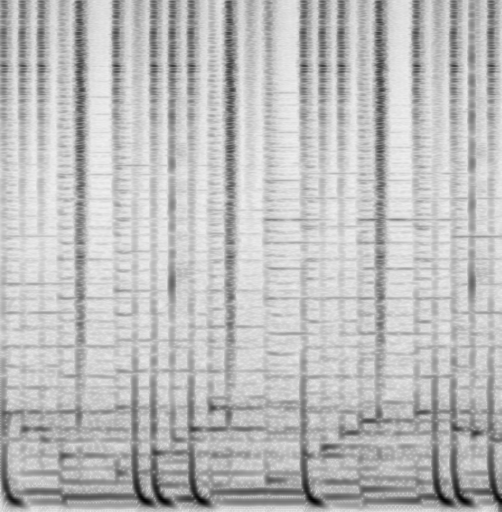

In [33]:
transformer.to_spectrogram("sample.wav", "sample.png")

Usput, pogledajmo i mel-spektrogram jednog od primjera isječka zvuka stila koji smo koristili za učenje.

Sample rate: 24000 Hz


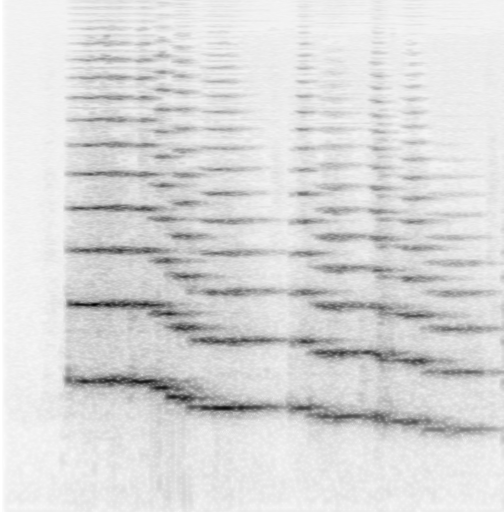

In [35]:
dataset = "cornet"
transformer.to_spectrogram(f"./audios/timbre/{dataset}/{dataset}1.wav", f"./audios/timbre/{dataset}/{dataset}1.png")

style = Image.open(f"./audios/timbre/{dataset}/{dataset}1.png")
style

## Prijenos stila

Učitajmo spremljenje parametre TVE modula. Nakon učitavanja, prenesimo stil na zadani uzorak sadržaja. Ovisno o hiperparametrima, moguće je dobiti drugačije rezultate. Broj koraka inferencije uglavnom se postavlja na 50, dok se parametri `scale` i `strength` mijenjaju. `scale` je parametar koji se koristi u tzv. classifier-free guidance-u, dok `strength` određuje koliko će se stil prenijeti. Veća vrijednost parametra `strength` označava jači prijenos stila (i obrnuto).

In [36]:
dataset = "cornet"
model.text_transform.tve.load_state_dict(torch.load(f"./data/{dataset}-tve.pth", weights_only=True))

<All keys matched successfully>

100%|██████████| 41/41 [00:08<00:00,  4.63it/s]


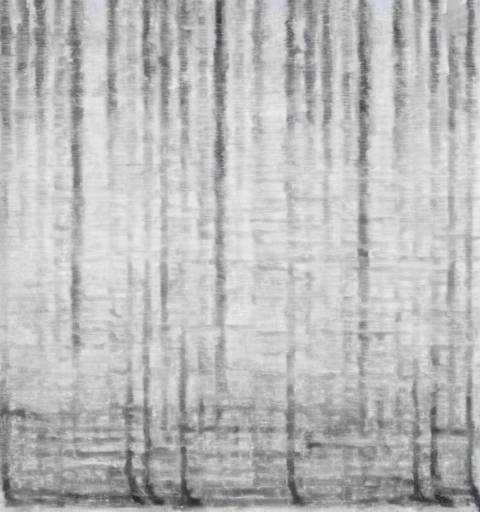

In [22]:
image = Image.open("sample.png")
#image = Image.open("./audios/timbre/cornet/data1.png")

image_stylized = model.transfer_style(
    image,
    "*",
    inference_steps=50,
    scale=3.5,
    strength=0.6,
    tve=True,
    bias_reduction=True
)

image_stylized.save("out_sample.png")
image_stylized

## Pretvorba slike u zvuk

Posljednji korak je pretvorba stilizirane sliku mel-spektrograma u zvuk.

In [24]:
transformer.to_audio("out_sample.png", "out_sample.wav")

Poslušajmo i primjer isječka zvuka stila koji smo koristili za treniranje.

In [29]:
transformer.to_audio(f"./audios/timbre/{dataset}/{dataset}1.png", f"./audios/timbre/{dataset}/{dataset}1.wav")

## Metrike

Za evaluaciju prijenosa stila koristimo dvije objektivne metrike. To su sačuvanost sadržaja (content preservation) i podudaranje stila (style fit). Obje metrike baziraju se na CLAP mjeri. CLAP mjera je jednaka kosinusnoj sličnosti ugrađivanja ograničenoj na interval [0-1]. 
  
U slučaju izračuna sačuvanosti sadržaja, koristimo isječak zvuka sadržaja, kao i stilizirani isječak zvuka sadržaja. Oba isječka postave se kao ulaz CLAP modelu (multimodalni model sličan CLIP-u, ulaz mu može biti tekst ili audio) te se za iste dobiju ugrađivanja u latentni prostor. Između tih ugrađivanja izračuna se kosinusna sličnost, a dobivena sličnost prolazi kroz zglobnicu. Na kraju dobivamo mjeru ograničenu na interval [0-1] koja predstavlja sačuvanost sadržaja.
  
U slučaju podudaranja stila, koriste se isječci zvuka stila, kao i stilizirani isječak zvuka sadržaja. U originalnom radu, umjesto isječaka zvuka stila koristi se tekstualni opis stila, no autori rada u skupu podataka nisu priložili tekstualne opise. Umjesto toga, za sve isječke zvuka stila (koji su korišteni za učenje modela) se izračunaju CLAP ugrađivanja te se na kraju uzima prosječno ugrađivanje isječaka zvuka stila. Ovo ugrađivanje, kao i ugrađivanje stiliziranog isječka zvuka sadržaja, koriste se za izračun kosinusne sličnosti. Na kraju dobivamo mjeru koja predstavlja podudaranje stila.

In [41]:
from metrics import content_preservation, style_fit

content = ["sample.wav"]
stylized_content = ["out_sample.wav"]
style = ["./audios/timbre/cornet/cornet1.wav", "./audios/timbre/cornet/cornet2.wav", "./audios/timbre/cornet/cornet3.wav"]

content_preservation_score = content_preservation(content, stylized_content) * 100
style_fit_score = style_fit(style, stylized_content) * 100

print(f"Content preservation: {content_preservation_score:.2f}")
print(f"Style fit: {style_fit_score:.2f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load our best checkpoint in the paper.
The checkpoint is already downloaded
Load Checkpoint...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load our best checkpoint in the paper.
The checkpoint is already downloaded
Load Checkpoint...
Content preservation: 51.70
Style fit: 14.09


Pogledajmo sada metrike na većem skupu primjera. Konkretno, prenijet ćemo naučeni stil na sve isječke zvuka sadržaja iz skupa podataka. Nakon toga, izračunat ćemo metrike na cijelom skupu podataka. Prije svega, sve isječke zvuka moramo pretvoriti u spektrograme.

In [54]:
transformer = Transform()
content_base_path = "./audios/content/"
stylized_base_path = "./audios/stylized_content/"

for folder_name in os.listdir(content_base_path):
    for file_name in os.listdir(os.path.join(content_base_path, folder_name)):
        if file_name.endswith(".wav"):
            sound_path = os.path.join(content_base_path, folder_name, file_name)
            img_path = os.path.join(content_base_path, folder_name, file_name.replace('.wav', '.png'))
            
            transformer.to_spectrogram(sound_path, img_path, False)

Prenesimo sada naučeni stil na sve isječke zvuka sadržaja.

In [ ]:
for folder_name in os.listdir(content_base_path):
    if not os.path.exists(os.path.join(stylized_base_path, folder_name)):
        os.makedirs(os.path.join(stylized_base_path, folder_name))

    for file_name in os.listdir(os.path.join(content_base_path, folder_name)):
        if file_name.endswith(".png"):
            img_path = os.path.join(content_base_path, folder_name, file_name)
            save_path = os.path.join(stylized_base_path, folder_name, file_name)

            image = Image.open(img_path)
            image_stylized = model.transfer_style(
                image,
                "*",
                inference_steps=50,
                scale=3.5,
                strength=0.6,
                tve=True,
                bias_reduction=True
            )

            image_stylized.save(save_path)

Pretvorimo sada dobivene stilizirane spektrograme u zvuk.

In [ ]:
for folder_name in os.listdir(stylized_base_path):
    for file_name in os.listdir(os.path.join(stylized_base_path, folder_name)):
        if file_name.endswith(".png"):
            img_path = os.path.join(stylized_base_path, folder_name, file_name)
            sound_path = os.path.join(stylized_base_path, folder_name, file_name.replace('.png', '.wav'))

            transformer.to_audio(img_path, sound_path)

Konačno, izračunajmo metrike na cijelom skupu podataka.

In [ ]:
style = ["./audios/timbre/cornet/cornet1.wav", "./audios/timbre/cornet/cornet2.wav", "./audios/timbre/cornet/cornet3.wav"]

content = []
stylized_content = []

for folder_name in os.listdir(content_base_path):
    for file_name in os.listdir(os.path.join(content_base_path, folder_name)):
        if file_name.endswith(".wav"):
            content.append(os.path.join(content_base_path, folder_name, file_name))

for folder_name in os.listdir(stylized_base_path):
    for file_name in os.listdir(os.path.join(stylized_base_path, folder_name)):
        if file_name.endswith(".wav"):
            stylized_content.append(os.path.join(stylized_base_path, folder_name, file_name))

content_preservation_score = content_preservation(content, stylized_content) * 100
style_fit_score = style_fit(style, stylized_content) * 100

print(f"Content preservation: {content_preservation_score:.2f}")
print(f"Style fit: {style_fit_score:.2f}")